In [1]:
# ============================
# IMPORT LIBRARY
# ============================
import simpy
import random
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple
import statistics

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


In [2]:
# ============================
# KONFIGURASI SIMULASI
# ============================
@dataclass
class Config:
    """Konfigurasi parameter simulasi"""
    # Parameter dasar
    NUM_MAHASISWA: int = 500          # Jumlah mahasiswa
    NUM_STAFF_PER_KELOMPOK: int = 2   # Staff per kelompok
    NUM_KELOMPOK: int = 2            # Jumlah kelompok
    
    # Distribusi waktu
    MIN_SERVICE_TIME: float = 1.0     # menit (waktu layanan minimal)
    MAX_SERVICE_TIME: float = 3.0     # menit (waktu layanan maksimal)
    
    # Waktu kedatangan (rata-rata antar kedatangan dalam menit)
    # Untuk 500 mahasiswa dalam 2 jam pertama (120 menit)
    MEAN_INTERARRIVAL: float = 120 / 500  # ~0.24 menit = 14.4 detik
    
    # Jam mulai
    START_HOUR: int = 8
    START_MINUTE: int = 0
    
    # Seed untuk reproduktibilitas
    RANDOM_SEED: int = 42

print("✅ Konfigurasi simulasi siap")

✅ Konfigurasi simulasi siap


In [3]:
# ============================
# MODEL SIMULASI
# ============================
class KantinPrasmananDES:
    """Model Discrete Event Simulation untuk kantin prasmanan IT Del"""
    
    def __init__(self, config: Config):
        self.config = config
        self.env = simpy.Environment()
        
        # Resources: Staff per kelompok
        # Setiap kelompok memiliki sejumlah staff
        self.kelompok_staff = [
            simpy.Resource(self.env, capacity=config.NUM_STAFF_PER_KELOMPOK)
            for _ in range(config.NUM_KELOMPOK)
        ]
        
        # Antrian tunggal untuk semua mahasiswa
        self.antrian = simpy.Store(self.env)
        
        # Statistik
        self.statistics = {
            'mahasiswa_data': [],  # Data setiap mahasiswa
            'queue_lengths': [],   # Panjang antrian setiap event
            'queue_times': [],     # Waktu tunggu setiap mahasiswa
            'service_times': [],   # Waktu layanan
            'utilization': {i: [] for i in range(config.NUM_KELOMPOK)}  # Utilisasi per kelompok
        }
        
        # Waktu mulai simulasi
        self.start_time = datetime(2024, 1, 1, config.START_HOUR, config.START_MINUTE)
        
        # Set random seed
        random.seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)
    
    def waktu_ke_jam(self, waktu_simulasi: float) -> datetime:
        """Konversi waktu simulasi (menit) ke datetime"""
        return self.start_time + timedelta(minutes=waktu_simulasi)
    
    def generate_service_time(self) -> float:
        """Generate waktu layanan (1-3 menit, seragam)"""
        return random.uniform(self.config.MIN_SERVICE_TIME, self.config.MAX_SERVICE_TIME)
    
    def generate_interarrival_time(self) -> float:
        """Generate waktu antar kedatangan (eksponensial)"""
        return random.expovariate(1.0 / self.config.MEAN_INTERARRIVAL)
    
    def proses_mahasiswa(self, mahasiswa_id: int):
        """Proses untuk satu mahasiswa dari kedatangan hingga selesai"""
        waktu_datang = self.env.now
        
        # 1. Masuk ke antrian
        yield self.antrian.put(mahasiswa_id)
        
        # Catat panjang antrian saat ini
        self.statistics['queue_lengths'].append({
            'time': self.env.now,
            'queue_length': len(self.antrian.items)
        })
        
        # 2. Tunggu sampai ada staff yang tersedia di kelompok mana pun
        kelompok_terpilih = None
        
        while kelompok_terpilih is None:
            # Cek setiap kelompok untuk staff yang tersedia
            for i, kelompok in enumerate(self.kelompok_staff):
                if kelompok.count < kelompok.capacity:
                    kelompok_terpilih = i
                    break
            
            if kelompok_terpilih is None:
                # Tunggu sebentar dan cek lagi
                yield self.env.timeout(0.01)
        
        # 3. Keluar dari antrian
        yield self.antrian.get()
        
        # 4. Hitung waktu tunggu
        waktu_mulai_layanan = self.env.now
        waktu_tunggu = waktu_mulai_layanan - waktu_datang
        
        # 5. Gunakan staff dari kelompok terpilih
        with self.kelompok_staff[kelompok_terpilih].request() as request:
            yield request
            
            # Catat utilisasi
            self.statistics['utilization'][kelompok_terpilih].append({
                'time': self.env.now,
                'in_use': self.kelompok_staff[kelompok_terpilih].count
            })
            
            # 6. Proses layanan
            service_time = self.generate_service_time()
            yield self.env.timeout(service_time)
            
            # 7. Selesai
            waktu_selesai = self.env.now
            
            # Simpan data mahasiswa
            self.statistics['mahasiswa_data'].append({
                'id': mahasiswa_id,
                'waktu_datang': waktu_datang,
                'waktu_mulai': waktu_mulai_layanan,
                'waktu_selesai': waktu_selesai,
                'waktu_tunggu': waktu_tunggu,
                'waktu_layanan': service_time,
                'kelompok': kelompok_terpilih,
                'jam_datang': self.waktu_ke_jam(waktu_datang),
                'jam_selesai': self.waktu_ke_jam(waktu_selesai)
            })
            
            self.statistics['queue_times'].append(waktu_tunggu)
            self.statistics['service_times'].append(service_time)
    
    def proses_kedatangan(self):
        """Generate kedatangan mahasiswa"""
        for i in range(self.config.NUM_MAHASISWA):
            # Process mahasiswa
            self.env.process(self.proses_mahasiswa(i))
            
            # Generate waktu antar kedatangan untuk mahasiswa berikutnya
            if i < self.config.NUM_MAHASISWA - 1:
                interarrival = self.generate_interarrival_time()
                yield self.env.timeout(interarrival)
    
    def run_simulation(self):
        """Jalankan simulasi"""
        # Start proses kedatangan
        self.env.process(self.proses_kedatangan())
        
        # Run simulasi sampai semua event selesai
        self.env.run()
        
        return self.analyze_results()
    
    def analyze_results(self):
        """Analisis hasil simulasi"""
        if not self.statistics['mahasiswa_data']:
            return None
        
        df = pd.DataFrame(self.statistics['mahasiswa_data'])
        
        # Hitung statistik
        results = {
            'total_mahasiswa': len(df),
            'waktu_selesai_terakhir': df['waktu_selesai'].max(),
            'jam_selesai_terakhir': self.waktu_ke_jam(df['waktu_selesai'].max()),
            
            # Statistik waktu tunggu
            'avg_waktu_tunggu': df['waktu_tunggu'].mean(),
            'max_waktu_tunggu': df['waktu_tunggu'].max(),
            'min_waktu_tunggu': df['waktu_tunggu'].min(),
            'std_waktu_tunggu': df['waktu_tunggu'].std(),
            
            # Statistik waktu layanan
            'avg_waktu_layanan': df['waktu_layanan'].mean(),
            'total_waktu_layanan': df['waktu_layanan'].sum(),
            
            # Utilisasi
            'utilisasi_kelompok': {},
            
            # Distribusi per jam
            'distribusi_jam': self.calculate_hourly_distribution(df)
        }
        
        # Hitung utilisasi per kelompok
        total_simulation_time = df['waktu_selesai'].max()
        for kelompok in range(self.config.NUM_KELOMPOK):
            kelompok_df = df[df['kelompok'] == kelompok]
            if len(kelompok_df) > 0:
                total_service_time = kelompok_df['waktu_layanan'].sum()
                utilisation = (total_service_time / 
                             (total_simulation_time * self.config.NUM_STAFF_PER_KELOMPOK)) * 100
                results['utilisasi_kelompok'][kelompok] = utilisation
            else:
                results['utilisasi_kelompok'][kelompok] = 0
        
        return results, df
    
    def calculate_hourly_distribution(self, df):
        """Hitung distribusi mahasiswa per jam"""
        df['jam'] = df['jam_selesai'].dt.hour
        hourly = df.groupby('jam').size().reset_index(name='jumlah')
        
        # Konversi ke dictionary
        return dict(zip(hourly['jam'], hourly['jumlah']))

print("✅ Model simulasi siap")

✅ Model simulasi siap


In [4]:

# ============================
# VISUALISASI DAN ANALISIS
# ============================
def run_scenario(num_mahasiswa: int, num_staff_per_kelompok: int, num_kelompok: int = 2):
    """Jalankan simulasi dengan parameter tertentu"""
    print(f"\n{'='*60}")
    print(f"SIMULASI KANTIN IT DEL - PRASMANAN")
    print(f"{'='*60}")
    print(f"Jumlah Mahasiswa: {num_mahasiswa}")
    print(f"Jumlah Kelompok: {num_kelompok}")
    print(f"Staff per Kelompok: {num_staff_per_kelompok}")
    print(f"Total Staff: {num_kelompok * num_staff_per_kelompok}")
    print(f"{'='*60}")
    
    # Setup konfigurasi
    config = Config(
        NUM_MAHASISWA=num_mahasiswa,
        NUM_STAFF_PER_KELOMPOK=num_staff_per_kelompok,
        NUM_KELOMPOK=num_kelompok
    )
    
    # Create dan run model
    model = KantinPrasmananDES(config)
    results, df = model.run_simulation()
    
    # Tampilkan hasil
    if results:
        print("\n📊 HASIL SIMULASI:")
        print(f"Jam mulai: {model.start_time.strftime('%H:%M')}")
        print(f"Jam selesai terakhir: {results['jam_selesai_terakhir'].strftime('%H:%M')}")
        print(f"Durasi total: {results['waktu_selesai_terakhir']:.2f} menit")
        print(f"Total waktu operasi: {(results['jam_selesai_terakhir'] - model.start_time)}")
        
        print(f"\n⏱️  STATISTIK WAKTU TUNGGU:")
        print(f"  Rata-rata: {results['avg_waktu_tunggu']:.2f} menit")
        print(f"  Maksimum: {results['max_waktu_tunggu']:.2f} menit")
        print(f"  Minimum: {results['min_waktu_tunggu']:.2f} menit")
        print(f"  Standar Deviasi: {results['std_waktu_tunggu']:.2f} menit")
        
        print(f"\n👨•🍳 STATISTIK WAKTU LAYANAN:")
        print(f"  Rata-rata: {results['avg_waktu_layanan']:.2f} menit")
        print(f"  Total: {results['total_waktu_layanan']:.2f} menit")
        
        print(f"\n📈 UTILISASI STAFF:")
        for kelompok, util in results['utilisasi_kelompok'].items():
            print(f"  Kelompok {kelompok+1}: {util:.1f}%")
        
        print(f"\n🕐 DISTRIBUSI PER JAM:")
        for jam in sorted(results['distribusi_jam'].keys()):
            print(f"  Jam {jam:02d}:00 - {results['distribusi_jam'][jam]:3d} mahasiswa")
    
    return results, df, model


def visualize_results(df, model, scenario_name=""):
    """Visualisasi hasil simulasi"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Hasil Simulasi Kantin IT Del {scenario_name}', fontsize=14, fontweight='bold')
    
    # 1. Distribusi Waktu Tunggu
    axes[0, 0].hist(df['waktu_tunggu'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(df['waktu_tunggu'].mean(), color='red', linestyle='--', 
                      label=f'Rata-rata: {df["waktu_tunggu"].mean():.2f} menit')
    axes[0, 0].set_xlabel('Waktu Tunggu (menit)')
    axes[0, 0].set_ylabel('Frekuensi')
    axes[0, 0].set_title('Distribusi Waktu Tunggu Mahasiswa')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Timeline Kedatangan vs Selesai
    axes[0, 1].scatter(df['waktu_datang'], df['id'], alpha=0.5, s=10, label='Kedatangan')
    axes[0, 1].scatter(df['waktu_selesai'], df['id'], alpha=0.5, s=10, label='Selesai')
    axes[0, 1].set_xlabel('Waktu Simulasi (menit)')
    axes[0, 1].set_ylabel('ID Mahasiswa')
    axes[0, 1].set_title('Timeline Kedatangan dan Penyelesaian')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Distribusi per Jam
    hourly_counts = df['jam_selesai'].dt.hour.value_counts().sort_index()
    axes[1, 0].bar(hourly_counts.index, hourly_counts.values, width=0.6)
    axes[1, 0].set_xlabel('Jam')
    axes[1, 0].set_ylabel('Jumlah Mahasiswa')
    axes[1, 0].set_title('Distribusi Penyelesaian per Jam')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Waktu Layanan per Kelompok
    kelompok_data = []
    kelompok_labels = []
    for kelompok in sorted(df['kelompok'].unique()):
        kelompok_df = df[df['kelompok'] == kelompok]
        kelompok_data.append(kelompok_df['waktu_layanan'].values)
        kelompok_labels.append(f'Kelompok {kelompok+1}')
    
    axes[1, 1].boxplot(kelompok_data, tick_labels=kelompok_labels)
    axes[1, 1].set_ylabel('Waktu Layanan (menit)')
    axes[1, 1].set_title('Waktu Layanan per Kelompok Staff')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def sensitivity_analysis():
    """Analisis sensitivitas dengan variasi parameter"""
    scenarios = [
        {"num_mahasiswa": 500, "num_staff": 2, "num_kelompok": 2},
        {"num_mahasiswa": 500, "num_staff": 3, "num_kelompok": 2},
        {"num_mahasiswa": 500, "num_staff": 1, "num_kelompok": 2},
        {"num_mahasiswa": 750, "num_staff": 2, "num_kelompok": 2},
        {"num_mahasiswa": 300, "num_staff": 2, "num_kelompok": 2},
        {"num_mahasiswa": 500, "num_staff": 2, "num_kelompok": 3},
    ]
    
    results_summary = []
    
    for i, scenario in enumerate(scenarios):        
        config = Config(
            NUM_MAHASISWA=scenario["num_mahasiswa"],
            NUM_STAFF_PER_KELOMPOK=scenario["num_staff"],
            NUM_KELOMPOK=scenario["num_kelompok"]
        )
        
        model = KantinPrasmananDES(config)
        results, df = model.run_simulation()
        
        if results:
            results_summary.append({
                'Scenario': i+1,
                'Mahasiswa': scenario["num_mahasiswa"],
                'Staff/Kelompok': scenario["num_staff"],
                'Kelompok': scenario["num_kelompok"],
                'Total Staff': scenario["num_staff"] * scenario["num_kelompok"],
                'Jam Selesai': results['jam_selesai_terakhir'].strftime('%H:%M'),
                'Avg Tunggu (menit)': f"{results['avg_waktu_tunggu']:.2f}",
                'Max Tunggu (menit)': f"{results['max_waktu_tunggu']:.2f}",
                'Utilisasi (%)': f"{np.mean(list(results['utilisasi_kelompok'].values())):.1f}"
            })
    
    # Tampilkan tabel perbandingan
    print(f"\n{'='*80}")
    print(f"{'PERBANDINGAN SEMUA SKENARIO':^80}")
    print(f"{'='*80}")
    
    summary_df = pd.DataFrame(results_summary)
    print(summary_df.to_string(index=False))
    
    return summary_df

print("✅ Fungsi visualisasi dan analisis siap")

✅ Fungsi visualisasi dan analisis siap


DISCRETE EVENT SIMULATION - KANTIN PRASMANAN IT DEL

SIMULASI KANTIN IT DEL - PRASMANAN
Jumlah Mahasiswa: 500
Jumlah Kelompok: 2
Staff per Kelompok: 2
Total Staff: 4

📊 HASIL SIMULASI:
Jam mulai: 08:00
Jam selesai terakhir: 12:18
Durasi total: 258.58 menit
Total waktu operasi: 4:18:34.934897

⏱️  STATISTIK WAKTU TUNGGU:
  Rata-rata: 62.91 menit
  Maksimum: 228.62 menit
  Minimum: 0.00 menit
  Standar Deviasi: 59.62 menit

👨•🍳 STATISTIK WAKTU LAYANAN:
  Rata-rata: 2.06 menit
  Total: 1028.86 menit

📈 UTILISASI STAFF:
  Kelompok 1: 99.4%
  Kelompok 2: 99.5%

🕐 DISTRIBUSI PER JAM:
  Jam 08:00 - 119 mahasiswa
  Jam 09:00 - 117 mahasiswa
  Jam 10:00 - 113 mahasiswa
  Jam 11:00 - 114 mahasiswa
  Jam 12:00 -  37 mahasiswa


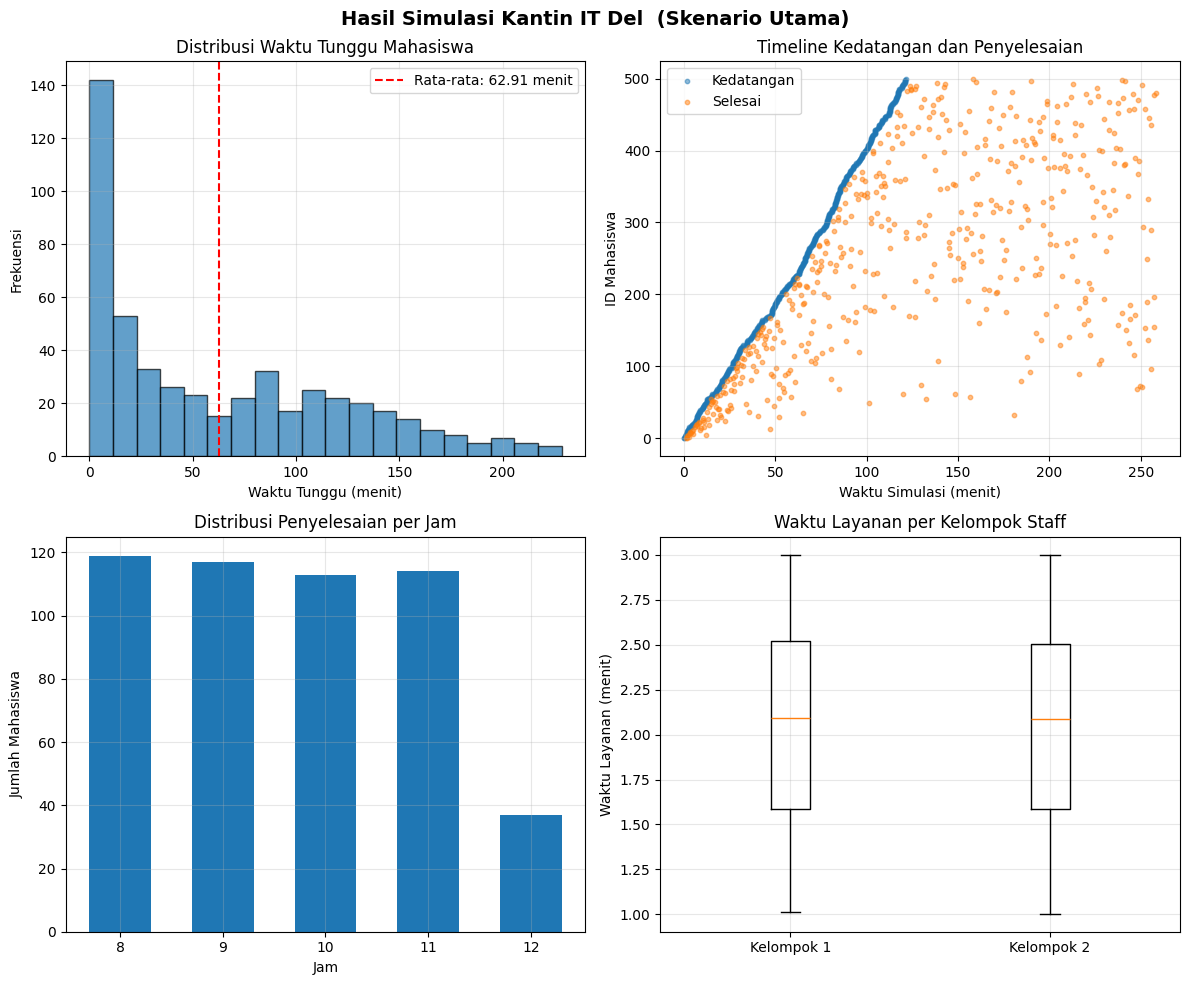

In [5]:
# ============================
# Menjalankan Simulasi
# ============================
print("DISCRETE EVENT SIMULATION - KANTIN PRASMANAN IT DEL")
print("="*60)

# SKENARIO UTAMA (Kasus Awal)
results, df, model = run_scenario(
    num_mahasiswa=500,
    num_staff_per_kelompok=2,
    num_kelompok=2
)

# Visualisasi untuk skenario utama
visualize_results(df, model, " (Skenario Utama)")

In [6]:
# ======================================
# CONTOH SIMULASI dengan KONDISI BERBEDA
# ======================================

# Contoh 1: Ubah jumlah mahasiswa menjadi 750
print("\n" + "="*60)
print("CONTOH 1: 750 MAHASISWA")
print("="*60)
results1, df1, model1 = run_scenario(
    num_mahasiswa=750,
    num_staff_per_kelompok=2,
    num_kelompok=2
)


CONTOH 1: 750 MAHASISWA

SIMULASI KANTIN IT DEL - PRASMANAN
Jumlah Mahasiswa: 750
Jumlah Kelompok: 2
Staff per Kelompok: 2
Total Staff: 4

📊 HASIL SIMULASI:
Jam mulai: 08:00
Jam selesai terakhir: 14:16
Durasi total: 376.62 menit
Total waktu operasi: 6:16:37.257195

⏱️  STATISTIK WAKTU TUNGGU:
  Rata-rata: 92.71 menit
  Maksimum: 340.88 menit
  Minimum: 0.00 menit
  Standar Deviasi: 84.59 menit

👨•🍳 STATISTIK WAKTU LAYANAN:
  Rata-rata: 2.00 menit
  Total: 1502.31 menit

📈 UTILISASI STAFF:
  Kelompok 1: 99.7%
  Kelompok 2: 99.7%

🕐 DISTRIBUSI PER JAM:
  Jam 08:00 - 119 mahasiswa
  Jam 09:00 - 117 mahasiswa
  Jam 10:00 - 117 mahasiswa
  Jam 11:00 - 124 mahasiswa
  Jam 12:00 - 120 mahasiswa
  Jam 13:00 - 120 mahasiswa
  Jam 14:00 -  33 mahasiswa


In [7]:
# Contoh 2: Tambah staff menjadi 3 per kelompok
print("\n" + "="*60)
print("CONTOH 2: TAMBAH STAFF (3 per kelompok)")
print("="*60)
results2, df2, model2 = run_scenario(
    num_mahasiswa=500,
    num_staff_per_kelompok=3,
    num_kelompok=2
)


CONTOH 2: TAMBAH STAFF (3 per kelompok)

SIMULASI KANTIN IT DEL - PRASMANAN
Jumlah Mahasiswa: 500
Jumlah Kelompok: 2
Staff per Kelompok: 3
Total Staff: 6

📊 HASIL SIMULASI:
Jam mulai: 08:00
Jam selesai terakhir: 10:51
Durasi total: 171.84 menit
Total waktu operasi: 2:51:50.232665

⏱️  STATISTIK WAKTU TUNGGU:
  Rata-rata: 21.81 menit
  Maksimum: 149.06 menit
  Minimum: 0.00 menit
  Standar Deviasi: 26.34 menit

👨•🍳 STATISTIK WAKTU LAYANAN:
  Rata-rata: 2.03 menit
  Total: 1016.31 menit

📈 UTILISASI STAFF:
  Kelompok 1: 98.8%
  Kelompok 2: 98.4%

🕐 DISTRIBUSI PER JAM:
  Jam 08:00 - 174 mahasiswa
  Jam 09:00 - 178 mahasiswa
  Jam 10:00 - 148 mahasiswa


In [8]:
# Contoh 3: Tambah kelompok menjadi 3
print("\n" + "="*60)
print("CONTOH 3: TAMBAH KELOMPOK (3 kelompok)")
print("="*60)
results3, df3, model3 = run_scenario(
    num_mahasiswa=500,
    num_staff_per_kelompok=2,
    num_kelompok=3
)


CONTOH 3: TAMBAH KELOMPOK (3 kelompok)

SIMULASI KANTIN IT DEL - PRASMANAN
Jumlah Mahasiswa: 500
Jumlah Kelompok: 3
Staff per Kelompok: 2
Total Staff: 6

📊 HASIL SIMULASI:
Jam mulai: 08:00
Jam selesai terakhir: 10:51
Durasi total: 171.84 menit
Total waktu operasi: 2:51:50.232665

⏱️  STATISTIK WAKTU TUNGGU:
  Rata-rata: 21.81 menit
  Maksimum: 149.06 menit
  Minimum: 0.00 menit
  Standar Deviasi: 26.34 menit

👨•🍳 STATISTIK WAKTU LAYANAN:
  Rata-rata: 2.03 menit
  Total: 1016.31 menit

📈 UTILISASI STAFF:
  Kelompok 1: 98.3%
  Kelompok 2: 99.3%
  Kelompok 3: 98.1%

🕐 DISTRIBUSI PER JAM:
  Jam 08:00 - 174 mahasiswa
  Jam 09:00 - 178 mahasiswa
  Jam 10:00 - 148 mahasiswa


In [11]:
# Analisis Sensitivitas
print("ANALISIS SENSITIVITAS")
sensitivity_df = sensitivity_analysis()


ANALISIS SENSITIVITAS

                          PERBANDINGAN SEMUA SKENARIO                           
 Scenario  Mahasiswa  Staff/Kelompok  Kelompok  Total Staff Jam Selesai Avg Tunggu (menit) Max Tunggu (menit) Utilisasi (%)
        1        500               2         2            4       12:18              62.91             228.62          99.5
        2        500               3         2            6       10:51              21.81             149.06          98.6
        3        500               1         2            2       16:29             185.72             505.17          99.8
        4        750               2         2            4       14:16              92.71             340.88          99.7
        5        300               2         2            4       10:28              33.28             121.41          99.7
        6        500               2         3            6       10:51              21.81             149.06          98.6
